In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mp
from itertools import chain, islice
from scipy.stats import norm
from datetime import timedelta
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

***
## Data loading

In [2]:
split_date = "2021-03-01"

In [3]:
skus_for_assess = pd.read_csv("../data/skus_for_assess.csv")

data = (
    pd.read_parquet("../data/train.parquet")
    .query("sku in @skus_for_assess.sku")
    .reset_index(drop=True)
)

train = data.query("date <= @split_date")
valid = data.query("date > @split_date")

In [4]:
scales = (
    pd.read_csv("../data/scales.csv")
    .query("sku in @skus_for_assess.sku")
    .reset_index(drop=True)
)
scales

,sku,scale
0,1,1.025536
1,3,0.508548
2,4,2.463527
3,5,0.694808
4,6,1.050451
...,...,...
496792,660911,0.830455
496793,660912,1.033908
496794,660913,0.587220
496795,660914,1.203443


***
## Evaluating RMSSE

In [5]:
# mean prediction
pred_mean = train.groupby("sku")["sold_quantity"].mean().reset_index(name="y_pred")
results = list()

for site_id,valid_df in valid.groupby("site_id"):

    valid_df = valid_df[["date","sku","sold_quantity"]].rename({"sold_quantity":"y"}, axis=1)
    valid_df = pd.merge(valid_df, pred_mean, how="inner", on="sku")

    valid_df["sq_error"] = valid_df.eval("(y-y_pred)**2")
    mse = valid_df.groupby("sku")["sq_error"].mean().reset_index(name="mse")
    mrg = pd.merge(mse, scales, how="inner", on="sku")
    rmsse = mrg.eval("sqrt(mse)/scale").mean()
    
    results.append(rmsse)
    print(f"rmsse_{site_id}:", rmsse)
    
print("rmsse_AVG:", np.mean(results))

rmsse_MLA: 0.8303933774191458
rmsse_MLB: 0.8838208351519009
rmsse_MLM: 0.8455103955764058
rmsse_AVG: 0.8532415360491509


In [6]:
# median prediction
pred_median = train.groupby("sku")["sold_quantity"].median().reset_index(name="y_pred")
results = list()

for site_id,valid_df in valid.groupby("site_id"):

    valid_df = valid_df[["date","sku","sold_quantity"]].rename({"sold_quantity":"y"}, axis=1)
    valid_df = pd.merge(valid_df, pred_median, how="inner", on="sku")

    valid_df["sq_error"] = valid_df.eval("(y-y_pred)**2")
    mse = valid_df.groupby("sku")["sq_error"].mean().reset_index(name="mse")
    mrg = pd.merge(mse, scales, how="inner", on="sku")
    rmsse = mrg.eval("sqrt(mse)/scale").mean()
    
    results.append(rmsse)
    print(f"rmsse_{site_id}:", rmsse)
    
print("rmsse_AVG:", np.mean(results))

rmsse_MLA: 0.8641878394708425
rmsse_MLB: 0.9253747255806362
rmsse_MLM: 0.8707998345665615
rmsse_AVG: 0.8867874665393467


***
## Evaluating inventory days prediction

In [7]:
class LinearModel():
    """
    Linear model based on sold_quantity
    """
    def __init__(self, 
                 last_n_days=None, 
                 normalize=True):
        
        self.normalize = normalize
        self.last_n_days = last_n_days
        self.border_cases = 0
        self.normal_cases = 0
        
    def fit(self, data):
        """
        Store mean and std-dev for each SKU
        """
        
        if self.last_n_days != None:
            min_training_date = str((pd.to_datetime(data.date.max())-timedelta(days=self.last_n_days)).date())
        else:
            min_training_date = str(data.date.min().date())
            
        self.parameters = (data[data.date >= min_training_date]
                           .groupby('sku')
                           .agg({'sold_quantity':['mean', 'std']})
                           .sold_quantity
                           .to_dict())

        self.general_mean = data.sold_quantity.mean()
        self.general_std = data.sold_quantity.std()
        return self 
    
    def calc_probs(self, norm_dist):
        #cut probs in days
        days = np.arange(1,31)
        probs = norm_dist.pdf(days)
        
        #if prob is zero, replace with uniform
        if np.sum(probs) == 0:
            return np.ones(30) / 30

        if self.normalize:
            probs = probs / np.sum(probs)
        return probs
    
    def predict(self, idx, stock):
        """
        calculate mean and variance to stockout for a given SKU
        """
        #retrieve the mean and variance for the SKU
        if self.parameters['mean'].get(idx, 0.) != 0.:
            mean = self.parameters['mean'][idx]
            std = self.parameters['std'][idx]        
            self.normal_cases += 1
        else:
            #to catch border cases where there is no data in train or has all 0s.
            mean = self.general_mean
            std = self.general_std    
            self.border_cases += 1
            
        if std == 0. or np.isnan(std):
            std = self.general_std
        
        #convert quantities into days
        days_to_stockout = np.clip(stock/mean, a_min=1, a_max=30)
        std_days = (std / mean) * days_to_stockout
        return days_to_stockout, std_days
    
    def predict_proba(self, idx, stock):
        """
        Calculates the 30 days probs given a SKU and a target_stock
        """
        days_to_stockout, std_days = self.predict(idx, stock)
        norm_dist = norm(days_to_stockout, std_days)
        return self.calc_probs(norm_dist)
    
    def predict_batch(self, X, proba=True):
        """ 
        Predict probs for many SKUs 
        Input:
            X: List of Dicts with keys sku and target_stock
        """
        result = []
        for x in X:
            idx = x['sku']
            stock = x['target_stock']
            if proba:
                result.append((idx, self.predict_proba(idx, stock)))
            else:
                result.append((idx, self.predict(idx, stock)))
        return result

In [8]:
%%time
model = LinearModel(last_n_days=14, normalize=True)
model.fit(train)

CPU times: user 5.32 s, sys: 1.28 s, total: 6.59 s
Wall time: 7.09 s


In [10]:
# assessment of inventory_days prediction
valid = pd.read_csv("../data/validation_seed2.csv")

preds = list()
for sku,df in tqdm(valid.groupby("sku")):
    preds.append(model.predict(sku, df.target_stock.values[0])[0])
preds = pd.DataFrame(preds, columns=["days_to_stockout"])

100%|██████████| 496797/496797 [00:53<00:00, 9349.66it/s] 


RMSE (mean):  10.805054653779973
RMSE (median):  6.75
MAE (mean):  8.379574560641133
MAE (median):  6.75


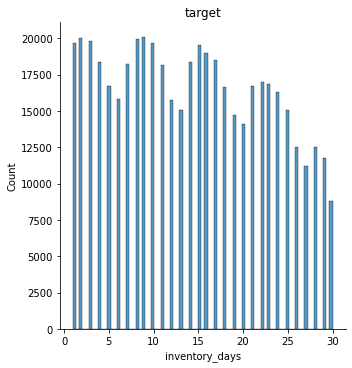

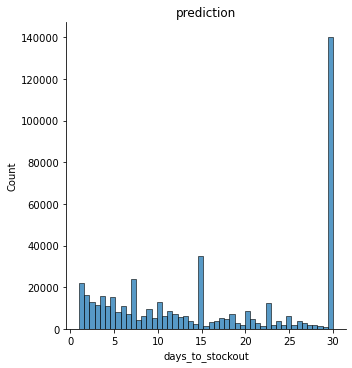

In [14]:
# huber loss
print("RMSE (mean): ", np.sqrt(np.mean((preds.days_to_stockout - valid.inventory_days)**2)) )
print("RMSE (median): ", np.sqrt(np.median((preds.days_to_stockout - valid.inventory_days)**2)) )
print("MAE (mean): ", np.mean(np.abs(preds.days_to_stockout - valid.inventory_days)))
print("MAE (median): ", np.median(np.abs(preds.days_to_stockout - valid.inventory_days)))

sns.displot(valid.inventory_days)
plt.title("target")
plt.show()

sns.displot(preds.days_to_stockout)
plt.title("prediction")
plt.show()

***
## Evaluating RPS

In [16]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float64)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

In [17]:
%%time
model = LinearModel(last_n_days=14, normalize=True)
model.fit(train)

CPU times: user 5.24 s, sys: 343 ms, total: 5.58 s
Wall time: 5.6 s


In [18]:
results = list()

for files in glob("../data/validation_seed*.csv"):
    valid = pd.read_csv(files)

    preds_proba = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds_proba.append(model.predict_proba(sku, df.target_stock.values[0]))
    preds_proba = np.array(preds_proba)
    
    rps = scoring_function(valid.inventory_days.values, preds_proba)
    results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
    print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 496797/496797 [07:11<00:00, 1151.75it/s]


{'file': 'validation_seed19', 'rps': 4.4008963320744625}


100%|██████████| 496797/496797 [08:00<00:00, 1034.02it/s]


{'file': 'validation_seed23', 'rps': 4.403163087155468}


100%|██████████| 496797/496797 [08:08<00:00, 1017.85it/s]


{'file': 'validation_seed3', 'rps': 4.4012072900826436}


100%|██████████| 496797/496797 [07:33<00:00, 1094.55it/s]


{'file': 'validation_seed2', 'rps': 4.402027495545257}


100%|██████████| 496797/496797 [07:12<00:00, 1148.02it/s]


{'file': 'validation_seed7', 'rps': 4.399458127429425}


100%|██████████| 496797/496797 [07:04<00:00, 1170.23it/s]


{'file': 'validation_seed5', 'rps': 4.39965237827791}


100%|██████████| 496797/496797 [06:48<00:00, 1214.86it/s]


{'file': 'validation_seed13', 'rps': 4.407075773551237}


100%|██████████| 496797/496797 [06:50<00:00, 1209.73it/s]


{'file': 'validation_seed11', 'rps': 4.405818241685371}


100%|██████████| 496797/496797 [06:59<00:00, 1184.92it/s]


{'file': 'validation_seed17', 'rps': 4.405409083483127}


In [19]:
pd.DataFrame(results)

,file,rps
0,validation_seed19,4.400896
1,validation_seed23,4.403163
2,validation_seed3,4.401207
3,validation_seed2,4.402027
4,validation_seed7,4.399458
5,validation_seed5,4.399652
6,validation_seed13,4.407076
7,validation_seed11,4.405818
8,validation_seed17,4.405409


***